In [21]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import classification_report

import copy
import time

Downloading dataset

In [22]:
# imagenet_data = torchvision.datasets.FashionMNIST('./data/fashion/')
trainLoader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data/fashion/', train=True, download=False, transform=transforms.Compose([
            transforms.ToTensor()
        ])
    ), batch_size=1024, shuffle=True, num_workers=1
)
testLoader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './data/fashion/', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor()
        ])
    ), batch_size=1024, shuffle=True, num_workers=1
)

In [23]:
print('No. of samples in train set:' + str(len(trainLoader.dataset)))
print('No. of samples in test set:' + str(len(testLoader.dataset)))

No. of samples in train set:60000
No. of samples in test set:10000


Check to see if it has loaded correctly

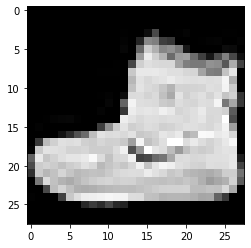

In [24]:
img = trainLoader.dataset[0][0]
img_np = img.squeeze(0).numpy()
plt.imshow(img_np, cmap='gray')

Defining AutoEncoder Class

In [25]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),  # Takes input and sends to 1st 100 neurons 
            nn.ReLU(),              # Goes through activation function 
            nn.Linear(100, 100),    # Takes input from 1st 100 neurons and goes through first hidden layer
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),    # goes through second hidden layer
            nn.ReLU(),              # Goes through activation function 
            nn.Linear(100, 28*28),  # Gives output as an image
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

In [26]:
def train_model_recon(model, criterion, optimizer, num_epochs):
    start = time.time()
    train_loss = []         # List for saving the loss per epoch

    for epoch in range(num_epochs):
        epochStartTime = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        running_loss = 0.0
        # Loading data in batches
        batch = 0
        for data in trainLoader:
            inputs,labels = data
            # Wrap them in variable
            # if use_gpu:
            #     inputs,labels = Variable(inputs.view(inputs.size(0), -1).cuda()), Variable(inputs.view(inputs.size(0), -1).cuda())
            # else:
            #     inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(inputs.view(inputs.size(0), -1))
            inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(inputs.view(inputs.size(0), -1))
            # Initializing model gradients to zero
            model.zero_grad()
            # Data feed-forward through the network
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagating the loss and updating the model parameters
            loss.backward()
            optimizer.step()

            # Accumulating the loss for each batch
            running_loss += loss
            if batch == 0:
                totalLoss = loss
                batch +=1
            else:
                totalLoss = loss
                batch +=1

        epoch_loss = running_loss/50000 # Total loss for 1 epoch
        train_loss.append(epoch_loss) # Saving the loss over epochs for plotting 

        print('Epoch loss: {:.6f}'.format(epoch_loss))
        epochTimeEnd = time.time() - epochStartTime
        print('Epoch complete in {:.0f}m {:.0f}s'.format(
            epochTimeEnd // 60, epochTimeEnd % 60
        ))
        print('-' * 25)

        # Plotting Loss vs Epochs
        # fig1 = plt.figure(1)
        # plt.plot(range(epoch+1), train_loss, 'r--', label = 'train')
        # if epoch == 0:
        #     plt.legend(loc='upper left')
        #     plt.xlabel('Epochs')
        #     plt.ylabel('Loss')
        # fig1.savefig('aeRecon_lossPlot.png')
    
    time_elapsed = time.time() - start
    print('Training complete in complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    return model


Model initialization and training

In [27]:
net = autoencoder()
print(net)
# if use_gpu:
#     net = net.cuda()
inti_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)


In [28]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.5, momentum=0.9)
net = train_model_recon(net, criterion, optimizer, num_epochs=20)

Epoch 0/19
Epoch loss: 0.000148
Epoch complete in 0m 14s
-------------------------
Epoch 1/19
Epoch loss: 0.000106
Epoch complete in 0m 15s
-------------------------
Epoch 2/19
Epoch loss: 0.000083
Epoch complete in 0m 13s
-------------------------
Epoch 3/19
Epoch loss: 0.000072
Epoch complete in 0m 12s
-------------------------
Epoch 4/19
Epoch loss: 0.000066
Epoch complete in 0m 16s
-------------------------
Epoch 5/19
Epoch loss: 0.000060
Epoch complete in 0m 14s
-------------------------
Epoch 6/19
Epoch loss: 0.000055
Epoch complete in 0m 13s
-------------------------
Epoch 7/19
Epoch loss: 0.000053
Epoch complete in 0m 13s
-------------------------
Epoch 8/19
Epoch loss: 0.000051
Epoch complete in 0m 15s
-------------------------
Epoch 9/19
Epoch loss: 0.000050
Epoch complete in 0m 14s
-------------------------
Epoch 10/19
Epoch loss: 0.000049
Epoch complete in 0m 14s
-------------------------
Epoch 11/19
Epoch loss: 0.000048
Epoch complete in 0m 13s
-------------------------
Ep

Reconstruction using autoencoder

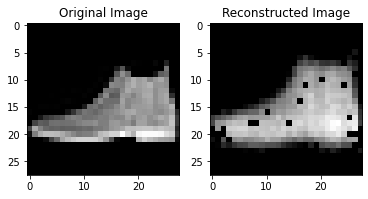

In [29]:
TestImg = testLoader.dataset[0][0]

# if use_gpu:
#     outputImg = net(Variable(TestImg.view(TestImg.size(0), -1)).cuda())
# else:
#     outputImg = net(Variable(TestImg.view(TestImg.size(0), -1)))

outputImg = net(Variable(TestImg.view(TestImg.size(0), -1)))

outputImg = outputImg.data.view(-1, 28, 28).cpu()

fig = plt.figure()

plot = fig.add_subplot(1, 2, 1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img, cmap='gray')

plot = fig.add_subplot(1, 2, 2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img, cmap='gray')

plt.show()

Visualization of weights of encoder

In [30]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

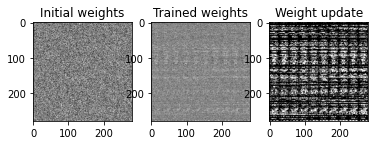

In [31]:
inti_weights = (1 + inti_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

# if use_gpu:
#     inti_weights = inti_weights.view(-1, 280, 280).byte().cpu()
#     trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
# else:
#     inti_weights = inti_weights.view(-1, 280, 280).byte()
#     trained_weights = trained_weights.view(-1, 280, 280).byte()
inti_weights = inti_weights.view(-1, 280, 280).byte()
trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = inti_weights - trained_weights

fig = plt.figure()

plot = fig.add_subplot(1,3,1)
img = np.array(inti_weights.numpy())[0]
plot.set_title('Initial weights')
imgplot = plt.imshow(img, cmap='gray')

plot = fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained weights')
imgplot = plt.imshow(img, cmap='gray')

plot = fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img, cmap='gray')

plt.show()

Autoencoder for classification

In [32]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100,10), nn.LogSoftmax()))
print(net)
# if use_gpu:
#     net = net.cuda()
call_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax(dim=None)
  )
)


Defining function for training the network for classification

In [33]:
def train_model_classifier(model, criterion, optimizer, num_epochs):
    start = time.time()
    train_loss = []         # List for saving the loss per epoch
    train_acc = []

    for epoch in range(num_epochs):
        epochStartTime = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        running_loss = 0.0
        running_corrects = 0.0
        # Loading data in batches
        batch = 0
        for data in trainLoader:
            inputs,labels = data
            # Wrap them in variable
            # if use_gpu:
            #     inputs,labels = Variable(inputs.view(inputs.size(0), -1).cuda()), Variable(inputs.view(inputs.size(0), -1).cuda())
            # else:
            #     inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(inputs.view(inputs.size(0), -1))
            inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(labels)
            # Initializing model gradients to zero
            model.zero_grad()
            # Data feed-forward through the network
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagating the loss and updating the model parameters
            loss.backward()
            optimizer.step()

            # Accumulating the loss for each batch
            running_loss += loss
            _, preds = torch.max(outputs.data, 1)

            # Accumulating correct predictions for each batch
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss/60000.0 # Total loss for 1 epoch
        train_loss.append(epoch_loss) # Saving the loss over epochs for plotting 
        epoch_acc = float(running_corrects) / 60000.0
        train_acc.append(epoch_acc)

        print('Epoch loss: {:.6f}, Epoch accuracy: {:.6f}'.format(epoch_loss, epoch_acc))
        epochTimeEnd = time.time() - epochStartTime
        print('Epoch complete in {:.0f}m {:.0f}s'.format(
            epochTimeEnd // 60, epochTimeEnd % 60
        ))
        print('-' * 25)

        # Plotting Loss vs Epochs
        # fig1 = plt.figure(1)
        # plt.plot(range(epoch+1), train_loss, 'r--', label = 'train')
        # if epoch == 0:
        #     plt.legend(loc='upper left')
        #     plt.xlabel('Epochs')
        #     plt.ylabel('Loss')
        # fig1.savefig('aeRecon_lossPlot.png')
    
    time_elapsed = time.time() - start
    print('Training complete in complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    return model

In [34]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = train_model_classifier(net, criterion, optimizer, num_epochs=20)

Epoch 0/19


c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch loss: 0.001259, Epoch accuracy: 0.548283
Epoch complete in 0m 15s
-------------------------
Epoch 1/19
Epoch loss: 0.000714, Epoch accuracy: 0.729033
Epoch complete in 0m 14s
-------------------------
Epoch 2/19
Epoch loss: 0.000628, Epoch accuracy: 0.775033
Epoch complete in 0m 15s
-------------------------
Epoch 3/19
Epoch loss: 0.000580, Epoch accuracy: 0.796067
Epoch complete in 0m 19s
-------------------------
Epoch 4/19
Epoch loss: 0.000545, Epoch accuracy: 0.809233
Epoch complete in 0m 17s
-------------------------
Epoch 5/19
Epoch loss: 0.000517, Epoch accuracy: 0.819833
Epoch complete in 0m 13s
-------------------------
Epoch 6/19
Epoch loss: 0.000495, Epoch accuracy: 0.827017
Epoch complete in 0m 13s
-------------------------
Epoch 7/19
Epoch loss: 0.000483, Epoch accuracy: 0.830867
Epoch complete in 0m 13s
-------------------------
Epoch 8/19
Epoch loss: 0.000466, Epoch accuracy: 0.835633
Epoch complete in 0m 14s
-------------------------
Epoch 9/19
Epoch loss: 0.00045

In [35]:
test_running_corr = 0

batches = 0
running_corrects = 0.0

for tsData in testLoader:
    inputs,labels = tsData
    # Wrap them in variable
    # if use_gpu:
    #     inputs,labels = Variable(inputs.view(inputs.size(0), -1).cuda()), Variable(inputs.view(inputs.size(0), -1).cuda())
    # else:
    #     inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(inputs.view(inputs.size(0), -1))
    inputs,labels = Variable(inputs.view(inputs.size(0), -1)), Variable(labels)
    # Initializing model gradients to zero
    output = net(inputs)
    _, preds = output.data.max(1)
    running_corrects += torch.sum(preds == labels.data)

ts_acc = running_corrects / 10000.0
print('Accuracy on test set = ' + str(ts_acc))

Accuracy on test set = tensor(0.8379)


<AxesSubplot:>

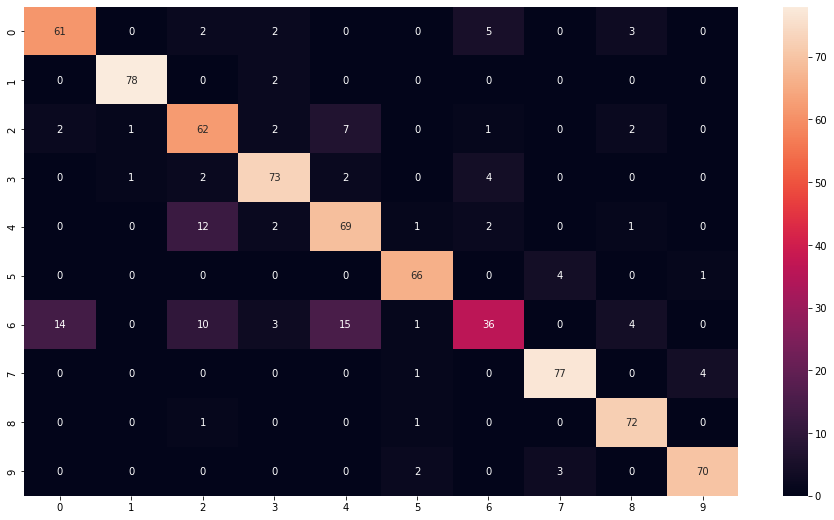

In [36]:
pyplot.figure(figsize=(16,9))
cm=confusion_matrix(labels.data,preds)

sns.heatmap(cm, annot=True, fmt='d')


In [37]:
cr= classification_report(labels.data,preds)

print(cr)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81        73
           1       0.97      0.97      0.97        80
           2       0.70      0.81      0.75        77
           3       0.87      0.89      0.88        82
           4       0.74      0.79      0.77        87
           5       0.92      0.93      0.92        71
           6       0.75      0.43      0.55        83
           7       0.92      0.94      0.93        82
           8       0.88      0.97      0.92        74
           9       0.93      0.93      0.93        75

    accuracy                           0.85       784
   macro avg       0.85      0.85      0.84       784
weighted avg       0.85      0.85      0.84       784

